In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns 

from code.model_managing import recreate_clf
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.model_selection import train_test_split
from code.cost_function import custom_cost_function

import random
random.seed(42)
np.random.seed(42)

For now, models have been trained only on one data split on train data set. In this situation, our best models could only perform good on the split that they were specifically trained on. We decided to train models on different splits and then analyse their performnce statistically to ensure their robustness, which is important in case of final test set that is unlabeled. 

In [2]:
X = pd.read_csv("data/x_train.txt", header=None, sep=" ")
y = pd.read_csv("data/y_train.txt", header=None)[0]
X_test_final = pd.read_csv("data/x_test.txt", header=None, sep=" ")

In [4]:
model_library = pd.read_csv('results/model_library_2.csv')

In [5]:
best_models = model_library.sort_values('Profit', ascending=False)[0:10].reset_index(drop=True)

In [ ]:
accuracies = []
precisions = []
profits = []
for i in range(len(best_models)):
    acc = []
    prec = []
    prof = []
    for j in range(50):
        print(j)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42+j)
        clf, features = recreate_clf(X_train, y_train, best_models, i)
        y_pred = clf.predict(X_test[features])
        acc.append(accuracy_score(y_test, y_pred))
        prec.append(precision_score(y_test, y_pred))
        prof.append(custom_cost_function(features, y_test, y_pred))
    accuracies.append(acc)
    precisions.append(prec)
    profits.append(prof)

In [5]:
names = []
for i in range(len(best_models)):
    model, features = best_models.loc[i][['Model', 'Features']]
    names.append(" ".join([model, features]))

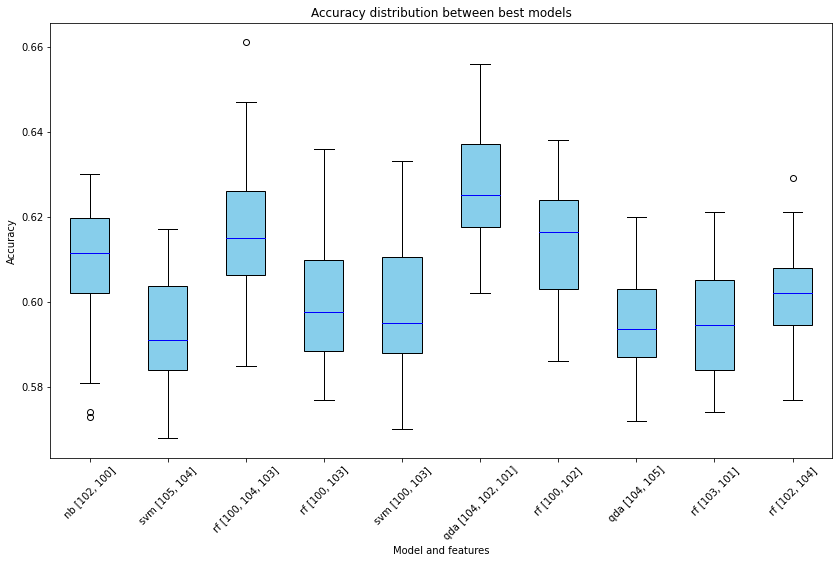

In [7]:
plt.figure(figsize=(14, 8))
bp = plt.boxplot(accuracies, patch_artist=True)
for box in bp['boxes']:
        box.set_facecolor('skyblue')
for median in bp['medians']:
        median.set(color='blue')
plt.xticks([i for i in range(1, 11)], names)
plt.title('Accuracy distribution between best models')
plt.xlabel('Model and features')
plt.xticks(rotation=45)
plt.ylabel('Accuracy')
plt.show()

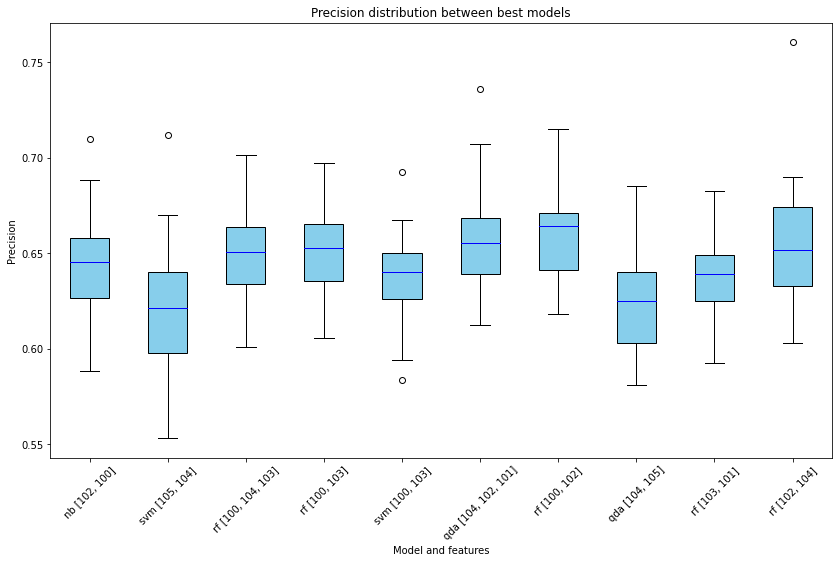

In [8]:
plt.figure(figsize=(14, 8))
bp = plt.boxplot(precisions, patch_artist=True)
for box in bp['boxes']:
        box.set_facecolor('skyblue')
for median in bp['medians']:
        median.set(color='blue')
plt.xticks([i for i in range(1, 11)], names)
plt.title('Precision distribution between best models')
plt.xlabel('Model and features')
plt.xticks(rotation=45)
plt.ylabel('Precision')
plt.show()

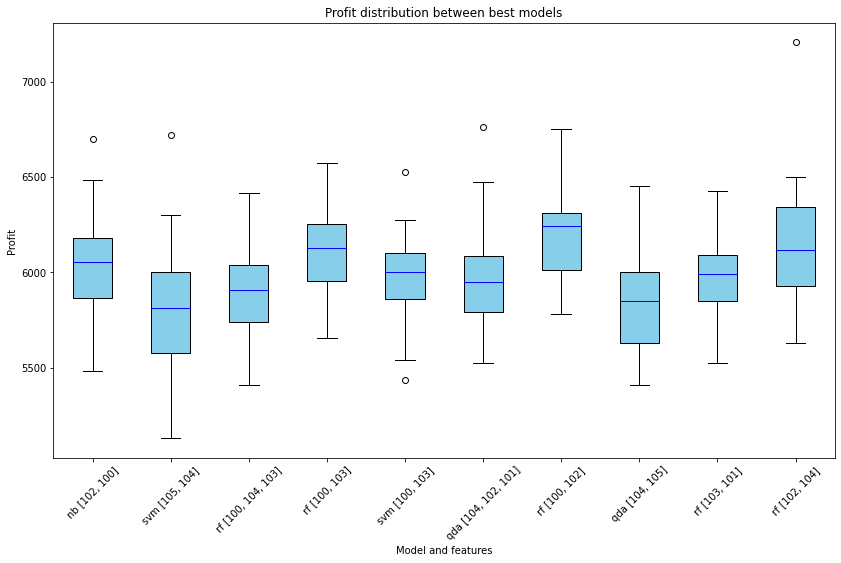

In [9]:
plt.figure(figsize=(14, 8))
bp = plt.boxplot(profits, patch_artist=True)
for box in bp['boxes']:
        box.set_facecolor('skyblue')
for median in bp['medians']:
        median.set(color='blue')
plt.xticks([i for i in range(1, 11)], names)
plt.title('Profit distribution between best models')
plt.xlabel('Model and features')
plt.xticks(rotation=45)
plt.ylabel('Profit')
plt.show()

We see that if looking at all 50 splits, if it comes to profit, random forest with features 100 and 102 generated the best results, altough it was only 7th in the initial ranking. This is why this model is preferable for final prediction on unseen data. But before that, we want to explore one more characteristic of models. We want to examine their precision on 20% of samples in test set, that obtained the biggest probability of belonging to class 1. This way we will imitate behaviour of classifiers on final test set, where only 20% of observations should be included in final outcome. We will check what the profit will be if we split train set equally to train and test and then select 500 observations from test set with highest probability of belonging to class 1.

In [ ]:
correct = []
profit = []
for i in range(len(best_models)):
    cor = []
    prof = []
    for j in range(50):
        print(j)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42+j)
        y_test.reset_index(drop=True, inplace=True)
        clf, features = recreate_clf(X_train, y_train, best_models, i)
        y_pred = clf.predict_proba(X_test[features])[:,1]
        top_positives_ind = y_pred.argsort()[::-1][0:500]
        correct_pos = np.sum(y_test[top_positives_ind])
        cor.append(correct_pos)
        profit_ = (correct_pos * 10 * 2) - (200 * len(features))
        prof.append(profit_)
    correct.append(cor)
    profit.append(prof)

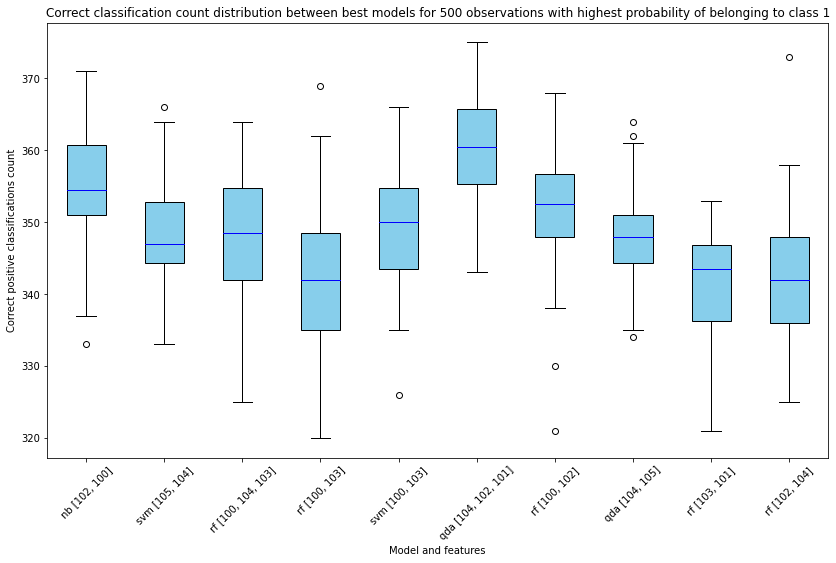

In [38]:
plt.figure(figsize=(14, 8))
bp = plt.boxplot(correct, patch_artist=True)
for box in bp['boxes']:
        box.set_facecolor('skyblue')
for median in bp['medians']:
        median.set(color='blue')
plt.xticks([i for i in range(1, 11)], names)
plt.title('Correct classification count distribution between best models for 500 observations with highest probability of belonging to class 1')
plt.xlabel('Model and features')
plt.xticks(rotation=45)
plt.ylabel('Correct positive classifications count')
plt.show()

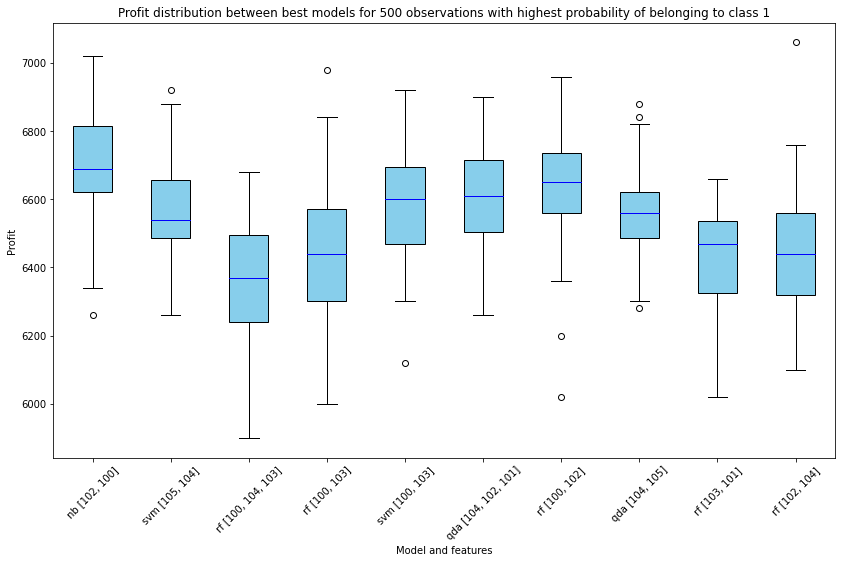

In [37]:
plt.figure(figsize=(14, 8))
bp = plt.boxplot(profit, patch_artist=True)
for box in bp['boxes']:
        box.set_facecolor('skyblue')
for median in bp['medians']:
        median.set(color='blue')
plt.xticks([i for i in range(1, 11)], names)
plt.title('Profit distribution between best models for 500 observations with highest probability of belonging to class 1')
plt.xlabel('Model and features')
plt.xticks(rotation=45)
plt.ylabel('Profit')
plt.show()

This perspective changed the best model on leaderboard. This time the naive bayes model with features 100 and 102 was the best. Taking the fact, that this experience was the closest one to project requirements, we decided to use Naive Bayes model as our final classifier. 

## Final prediction

In [13]:
clf, features = recreate_clf(X, y, best_models, 0)

In [19]:
proba_prediction = clf.predict_proba(X_test_final[features])[:,1]
top_positives_ind = proba_prediction.argsort()[::-1][0:1000]

In [21]:
top_positives_ind

array([4001, 1109, 4209, 2319, 2205,  262,  616,  115, 3249, 2274, 1871,
       4785, 2642, 4997, 3320,  586, 1859, 2937, 3961, 2786,  784,  231,
       1096,  588,  200, 1110, 3856, 2591,  621, 3714, 4268, 2260, 4621,
       2713, 3859, 4939, 2035, 3342, 3884,  602, 2583,  780, 4877,  218,
       4311,  142, 4201, 1604, 3463, 4652, 3164, 2703, 4578, 1509, 1547,
       3018, 4384, 1284, 2256, 1867, 3863, 1291, 3941, 4278,  557, 1135,
        570, 4380, 3114, 2173,  523, 4723, 2973,  250, 2813,  251,  749,
       3551, 1030, 3534, 2602, 2204, 1539, 4438, 1428,  773, 2779, 1113,
       2800, 1202,  368,  596, 4698, 2217, 4906, 4728,  425,  648, 2901,
       2296, 4197, 2505, 3516, 3571,  382, 4894, 1457,  861, 1380, 1138,
       1271, 3212,  613, 1335,  639, 1724, 1053, 3976,  958, 4566, 2600,
       4846, 3554, 2171, 2922, 1213,  416, 1438, 4230, 4715, 2865, 1399,
        372,   95, 4053, 1673, 4051, 3080,  559, 1285, 3966, 2214, 3192,
       4015, 1641, 2081, 1647, 3035, 4377, 3608, 20

In [26]:
with open("313451_obs.txt", "w") as f:
    for ind in top_positives_ind:
        f.write(str(ind) + "\n")

In [28]:
with open("313451_var.txt", "w") as f:
    for feat in features:
        f.write(str(feat) + "\n")